In [1]:
# import dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
IMAGES_PATH = "images"
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. Load the Data

In [3]:
train_values_path = os.path.join('..', 'Datasets' ,'train_values.csv')
X_train = pd.read_csv(train_values_path, index_col='building_id')

In [4]:
train_labels_path = os.path.join('..', 'Datasets' ,'train_labels.csv')
y_train = pd.read_csv(train_labels_path, index_col='building_id')

In [5]:
# combine the training values and labels 
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


## 2. Look at the Data Structure

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

Saving figure attribute_histogram_plots


FileNotFoundError: [Errno 2] No such file or directory: 'images/attribute_histogram_plots.png'

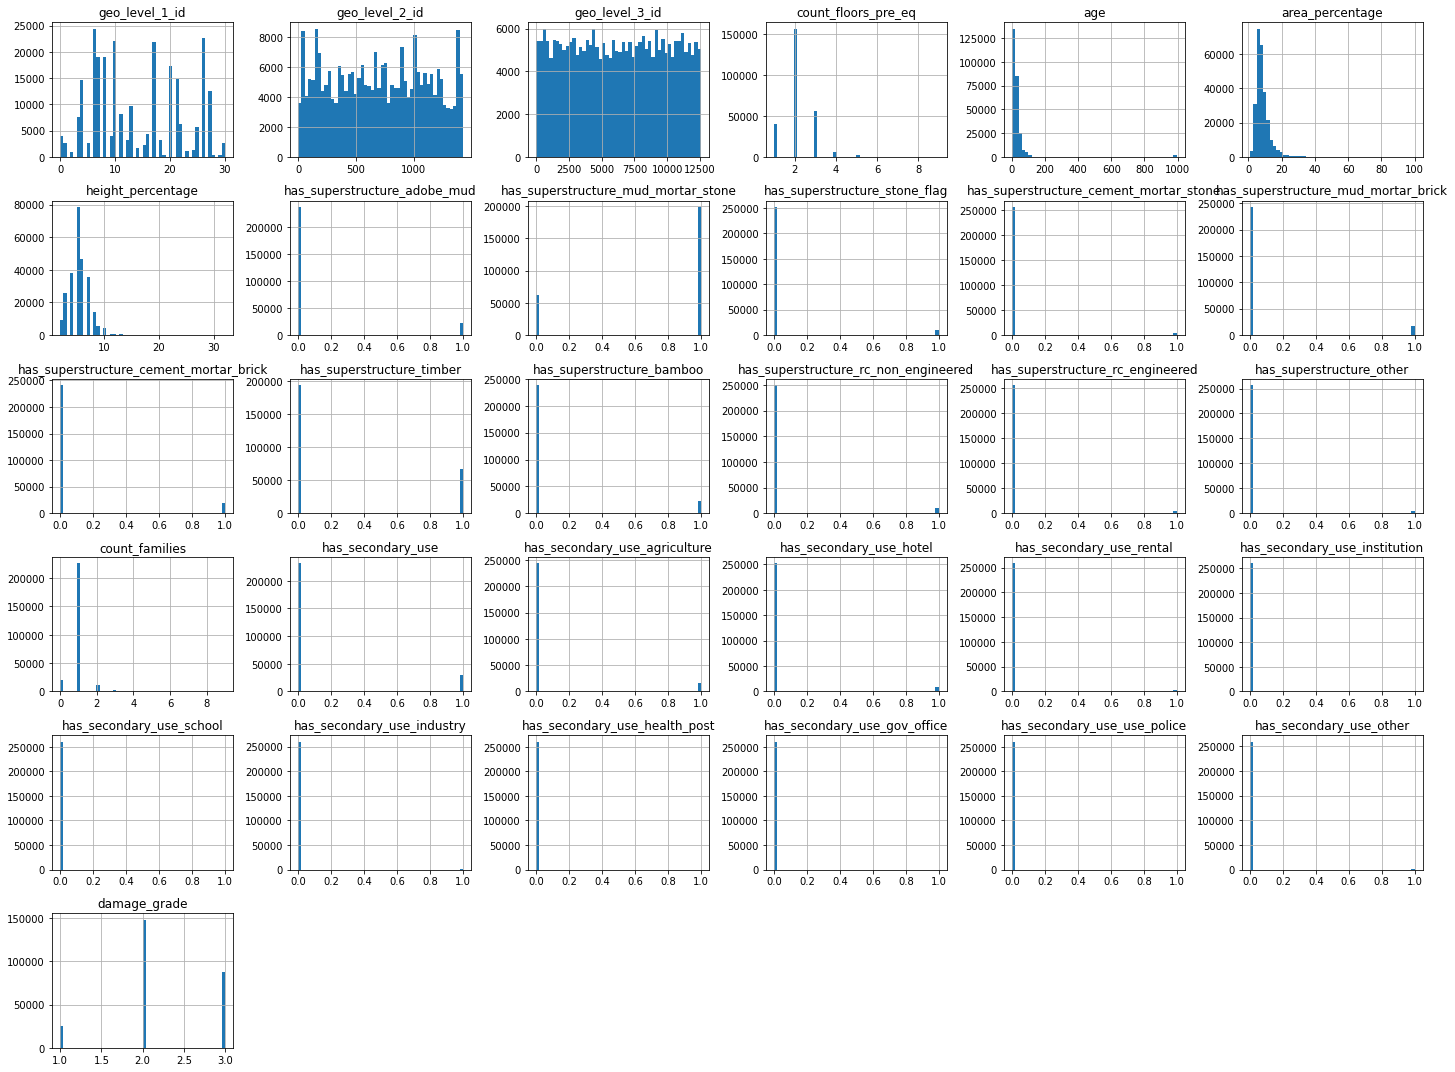

In [7]:
%matplotlib inline
train_df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# 3. Check Duplicated Data

In [8]:
# check for duplicated rows
duplicates = train_df.duplicated()
duplicates[duplicates > 1]

Series([], dtype: bool)

In [9]:
# check for duplicated columns
train_df.columns.duplicated().sum()

0

## 4. Checking for Missing Data

In [10]:
# check for missing values
missing_values = train_df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [11]:
# check for isna values
isna_values = train_df.isna().sum()
isna_values[isna_values > 0]

Series([], dtype: int64)

## 5. Check Feature Variance

In [12]:
# extract the numerical columns
train_df['has_superstructure_rc_engineered'].var()

0.015608030357799216

In [13]:
train_df['has_superstructure_other'].var()

0.014760111907650997

In [14]:
train_df['has_secondary_use_rental'].var()

0.008034918770280616

In [15]:
train_df['has_secondary_use_institution'].var()

0.0009392542864140481

In [16]:
train_df['has_secondary_use_school'].var()

0.00036057595456609633

In [17]:
train_df['has_secondary_use_industry'].var()

0.001069460099738735

In [18]:
train_df['has_secondary_use_health_post'].var()

0.000187992274296092

In [19]:
train_df['has_secondary_use_gov_office'].var()

0.0001457960819726822

In [20]:
train_df['has_secondary_use_use_police'].var()

8.825007704098355e-05

In [21]:
train_df['has_secondary_use_other'].var()

0.005092752642212146

## 6. Preprocess the Data

In [22]:
# extract the numerical columns 
numerical_columns = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# extract the categorical columns all the columns that are not numerical
categorical_columns = [col for col in X_train.columns if col not in numerical_columns]

In [23]:
# Pipeline for numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

# Pipeline for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features, ignore unknown categories in test data
])

# Create the ColumnTransformer to apply the transformations to the correct columns
full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Apply the full pipeline to the training data
X_train_prepared = full_pipeline.fit_transform(X_train)

In [25]:
# create a full pipeline to preprocess the data
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# preprocess the data
X_prepared = full_pipeline.fit_transform(X_train)

## 7. Dimensional Reductions

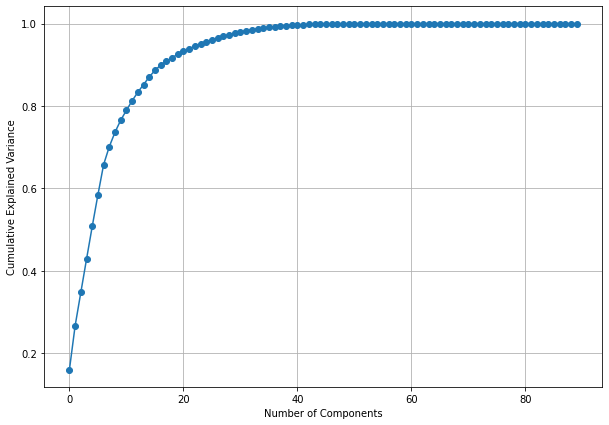

In [26]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_prepared)

# Plot the cumulative sum of eigenvalues (explained variance ratio)
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [27]:
# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative variance
cumulative_variance = explained_variance_ratio.cumsum()

In [28]:
# Find the number of components for 90% of explained variance
n_components_90_percent = (cumulative_variance >= 0.90).argmax() + 1

In [29]:
pca = PCA(n_components=n_components_90_percent)

# Fit and transform the data
X_pca = pca.fit_transform(X_prepared)

In [31]:
# Split the data into training and testing sets
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pca, y_train):
    X_train_processed, X_test_processed = X_pca[train_index], X_pca[test_index]
    y_train_processed, y_test_processed = y_train.iloc[train_index], y_train.iloc[test_index]

In [35]:
# Save the prepared data
X_train_processed_path = os.path.join('..', 'Datasets', 'X_train_processed.csv')
pd.DataFrame(X_train_processed).to_csv(X_train_processed_path, index=False, header=False)

X_test_processed_path = os.path.join('..', 'Datasets', 'X_test_processed.csv')
pd.DataFrame(X_test_processed).to_csv(X_test_processed_path, index=False, header=False)

y_train_processed_path = os.path.join('..', 'Datasets', 'y_train_processed.csv')
y_train_processed.to_csv(y_train_processed_path)

y_test_processed_path = os.path.join('..', 'Datasets', 'y_test_processed.csv')
y_test_processed.to_csv(y_test_processed_path)